
Compare Level 0 and Level 1 data



In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import glob
import seaborn as sns


Here, we define functions to read data from the laser disdrometer, LDQuant, Pluvio2, and radar and also define a function to calculate the rain rate from reflectivity using the Z-R relationship.


In [33]:


def rainrate_zr(Z_dBZ, a=200, b=1.6):
    rr = (10 ** (Z_dBZ / 10.0) / a) ** (1 / b)
    return rr

def read_and_process_ld(ld_path, start_time, end_time):
    ds = xr.open_mfdataset(ld_path)
    ld_df = ds.precip_rate.to_dataframe().rename(columns={'precip_rate': 'rain_ld'})
    ld_df = ld_df.loc[start_time:end_time]
    return ld_df

def read_and_process_ldq(ldq_path, start_time, end_time):
    ds = xr.open_mfdataset(ldq_path)
    ldq_df = ds.rain_rate.to_dataframe().rename(columns={'rain_rate': 'rain_ldq'})
    ldq_df = ldq_df.loc[start_time:end_time]
    return ldq_df

def read_and_process_pl2(pl2_path, start_time, end_time):
    ds = xr.open_mfdataset(pl2_path)
    pl2_df = ds.intensity_rtnrt.to_dataframe().rename(columns={'intensity_rtnrt': 'rain_pl2'})
    pl2_df = pl2_df.loc[start_time:end_time]
    return pl2_df

def read_and_process_radar(filename):
    df = pd.read_csv(filename, parse_dates=True)
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')
    df.index = df.index.round('min')
    df['rain_rate_zr'] = rainrate_zr(df['corrected_reflectivity'])
    return df

def merge_dataframes(primary_df, dfs_to_merge):
    reindexed_dfs = [df.reindex(primary_df.index) for df in dfs_to_merge]
    merged_df = pd.concat([primary_df] + reindexed_dfs, axis=1)
    return merged_df



In [34]:

def plot_pairplot(df, columns, filename=None):
    pairplot_fig = sns.pairplot(df[columns].dropna())
    if filename:
        pairplot_fig.savefig(filename)
    plt.show()

def plot_scatter(df, x_col, y_col, title, x_label, y_label, filename=None):
    """scatter plot."""
    plt.figure(figsize=(10, 6))
    plt.scatter(df[x_col], df[y_col], alpha=0.5)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    if filename:
        plt.savefig(filename)
    plt.show()

def plot_accumulated_rainfall(df, columns, title, filename=None):
    """Plot accumulated ."""
    plt.figure(figsize=(14, 8))
    for col in columns:
        plt.plot(df.index, df[col].cumsum(), label=col)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Accumulated Rainfall (mm)')
    plt.legend()
    plt.grid(True)
    if filename:
        plt.savefig(filename)
    plt.show()
    

def calculate_statistics(df, truth_col, estimate_cols):
    """Calculate stats and comparing"""
    stats = {}
    for col in estimate_cols:
        bias = (df[col] - df[truth_col]).mean()
        rmse = np.sqrt(((df[col] - df[truth_col]) ** 2).mean())
        correlation = df[[truth_col, col]].corr().iloc[0, 1]
        stats[col] = {'Bias': bias, 'RMSE': rmse, 'Correlation': correlation}
    return pd.DataFrame(stats)

def plot_time_series(df, columns, title, filename=None):
    """Plot ts."""
    plt.figure(figsize=(14, 8))
    for col in columns:
        plt.plot(df.index, df[col], label=col)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Rain Rate (mm/h)')
    plt.legend()
    plt.grid(True)
    if filename:
        plt.savefig(filename)
    plt.show()


def plot_histogram(df, columns, title, filename=None):
    """Plot histogram ."""
    # Determine the maximum value across all columns to define the bin edges
    max_val = max(df[columns].max())
    
    # Create bins from 0 to max_val with a step size of 1
    bins = np.arange(0, max_val + 1, 1)  # Bins are [0, 1), [1, 2), [2, 3), ..., [n, n+1)
    
    plt.figure(figsize=(14, 8))
    for col in columns:
        plt.hist(df[col].dropna(), bins=bins, alpha=0.5, label=col, log=True, histtype='step', linewidth=2)
    
    plt.title(title)
    plt.xlabel('Rain Rate (mm/h)')
    plt.ylabel('Frequency')
    plt.legend()
    if filename:
        plt.savefig(filename)
    plt.show()



def plot_scatter_comparison(df, truth_col, estimate_cols, filename_prefix=None):
    """Scatter plots comparing """
    for col in estimate_cols:
        plt.figure(figsize=(8, 6))
        plt.scatter(df[truth_col], df[col], alpha=0.5)
        plt.plot([df[truth_col].min(), df[truth_col].max()], [df[truth_col].min(), df[truth_col].max()], 'r--')
        plt.title(f'{col} vs {truth_col}')
        plt.xlabel(f'{truth_col} (mm/h)')
        plt.ylabel(f'{col} (mm/h)')
        plt.grid(True)
        if filename_prefix:
            plt.savefig(f'{filename_prefix}_{col}_vs_{truth_col}.png')
        plt.show()



Read data and merge it for common time index.



In [35]:
start_time = '2022-08-01 00'
end_time = '2022-08-31 00'

ld_path = glob.glob("/Users/bhupendra/projects/sail/data/gucldM1_b1/*.cdf")
ld_df = read_and_process_ld(ld_path, start_time, end_time)

ldq_path = glob.glob("/Users/bhupendra/projects/sail/data/gucldquantsM1_c1/*.nc")
ldq_df = read_and_process_ldq(ldq_path, start_time, end_time)

pl2_path = glob.glob("/Users/bhupendra/projects/sail/data/gucwbpluvio2M1_a1/*.nc")
pl2_df = read_and_process_pl2(pl2_path, start_time, end_time)

radar_filename = '/Users/bhupendra/projects/sail/data/output/radar_data_lev1.csv'
radar_df = read_and_process_radar(radar_filename)

dfs_to_merge = [pl2_df, ld_df, ldq_df]
merged_df = merge_dataframes(radar_df, dfs_to_merge)


### plot of Rain Rates



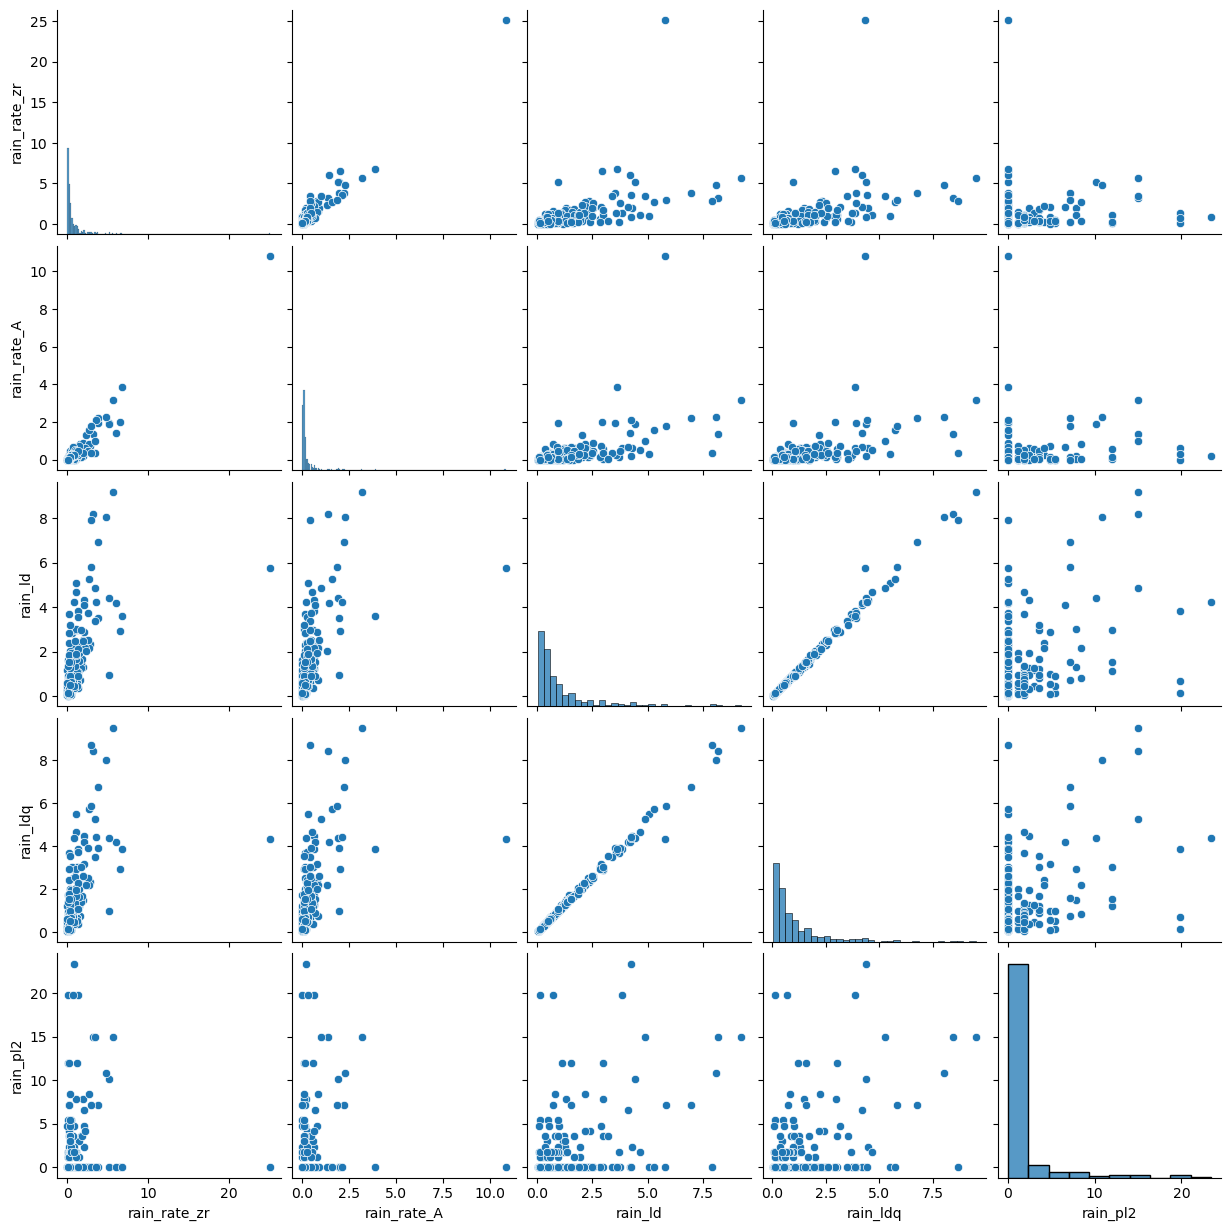

In [36]:

selected_columns = ['rain_rate_zr', 'rain_rate_A', 'rain_ld', 'rain_ldq', 'rain_pl2']
plot_pairplot(merged_df, selected_columns)



### Scatter Plot Comparison of Z-R and Attenuation-Based Rainfall

Now we plot comparing the Z-R rain rates with attenuation rain rates.
**attenuation based rainfall is underestimated**


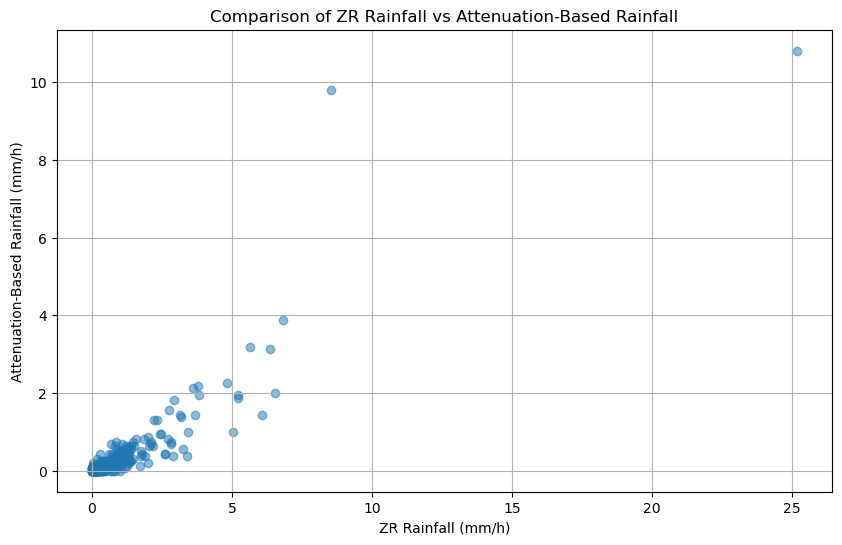

In [37]:
plot_scatter(radar_df, 'rain_rate_zr', 'rain_rate_A', 'Comparison of ZR Rainfall vs Attenuation-Based Rainfall', 'ZR Rainfall (mm/h)', 'Attenuation-Based Rainfall (mm/h)')



### Rainfall Accumulation

Accumulating rain over different intervals provides better comparisons between instruments. We calculate 15-minute, 30-minute, hourly, and daily rainfall accumulations.




In [38]:

def calculate_accumulations(df, rain_rate_columns, intervals):
    accumulations = {}
    for interval in intervals:
        accumulations[interval] = df[rain_rate_columns].resample(interval).sum()
    return accumulations



###  Compare Accumulations
##### Scatter Plots for Hourly Accumulation

PLot ourly rainfall accumulations from Z-R and attenuation-based methods compare with pl2 and ldq measurements.



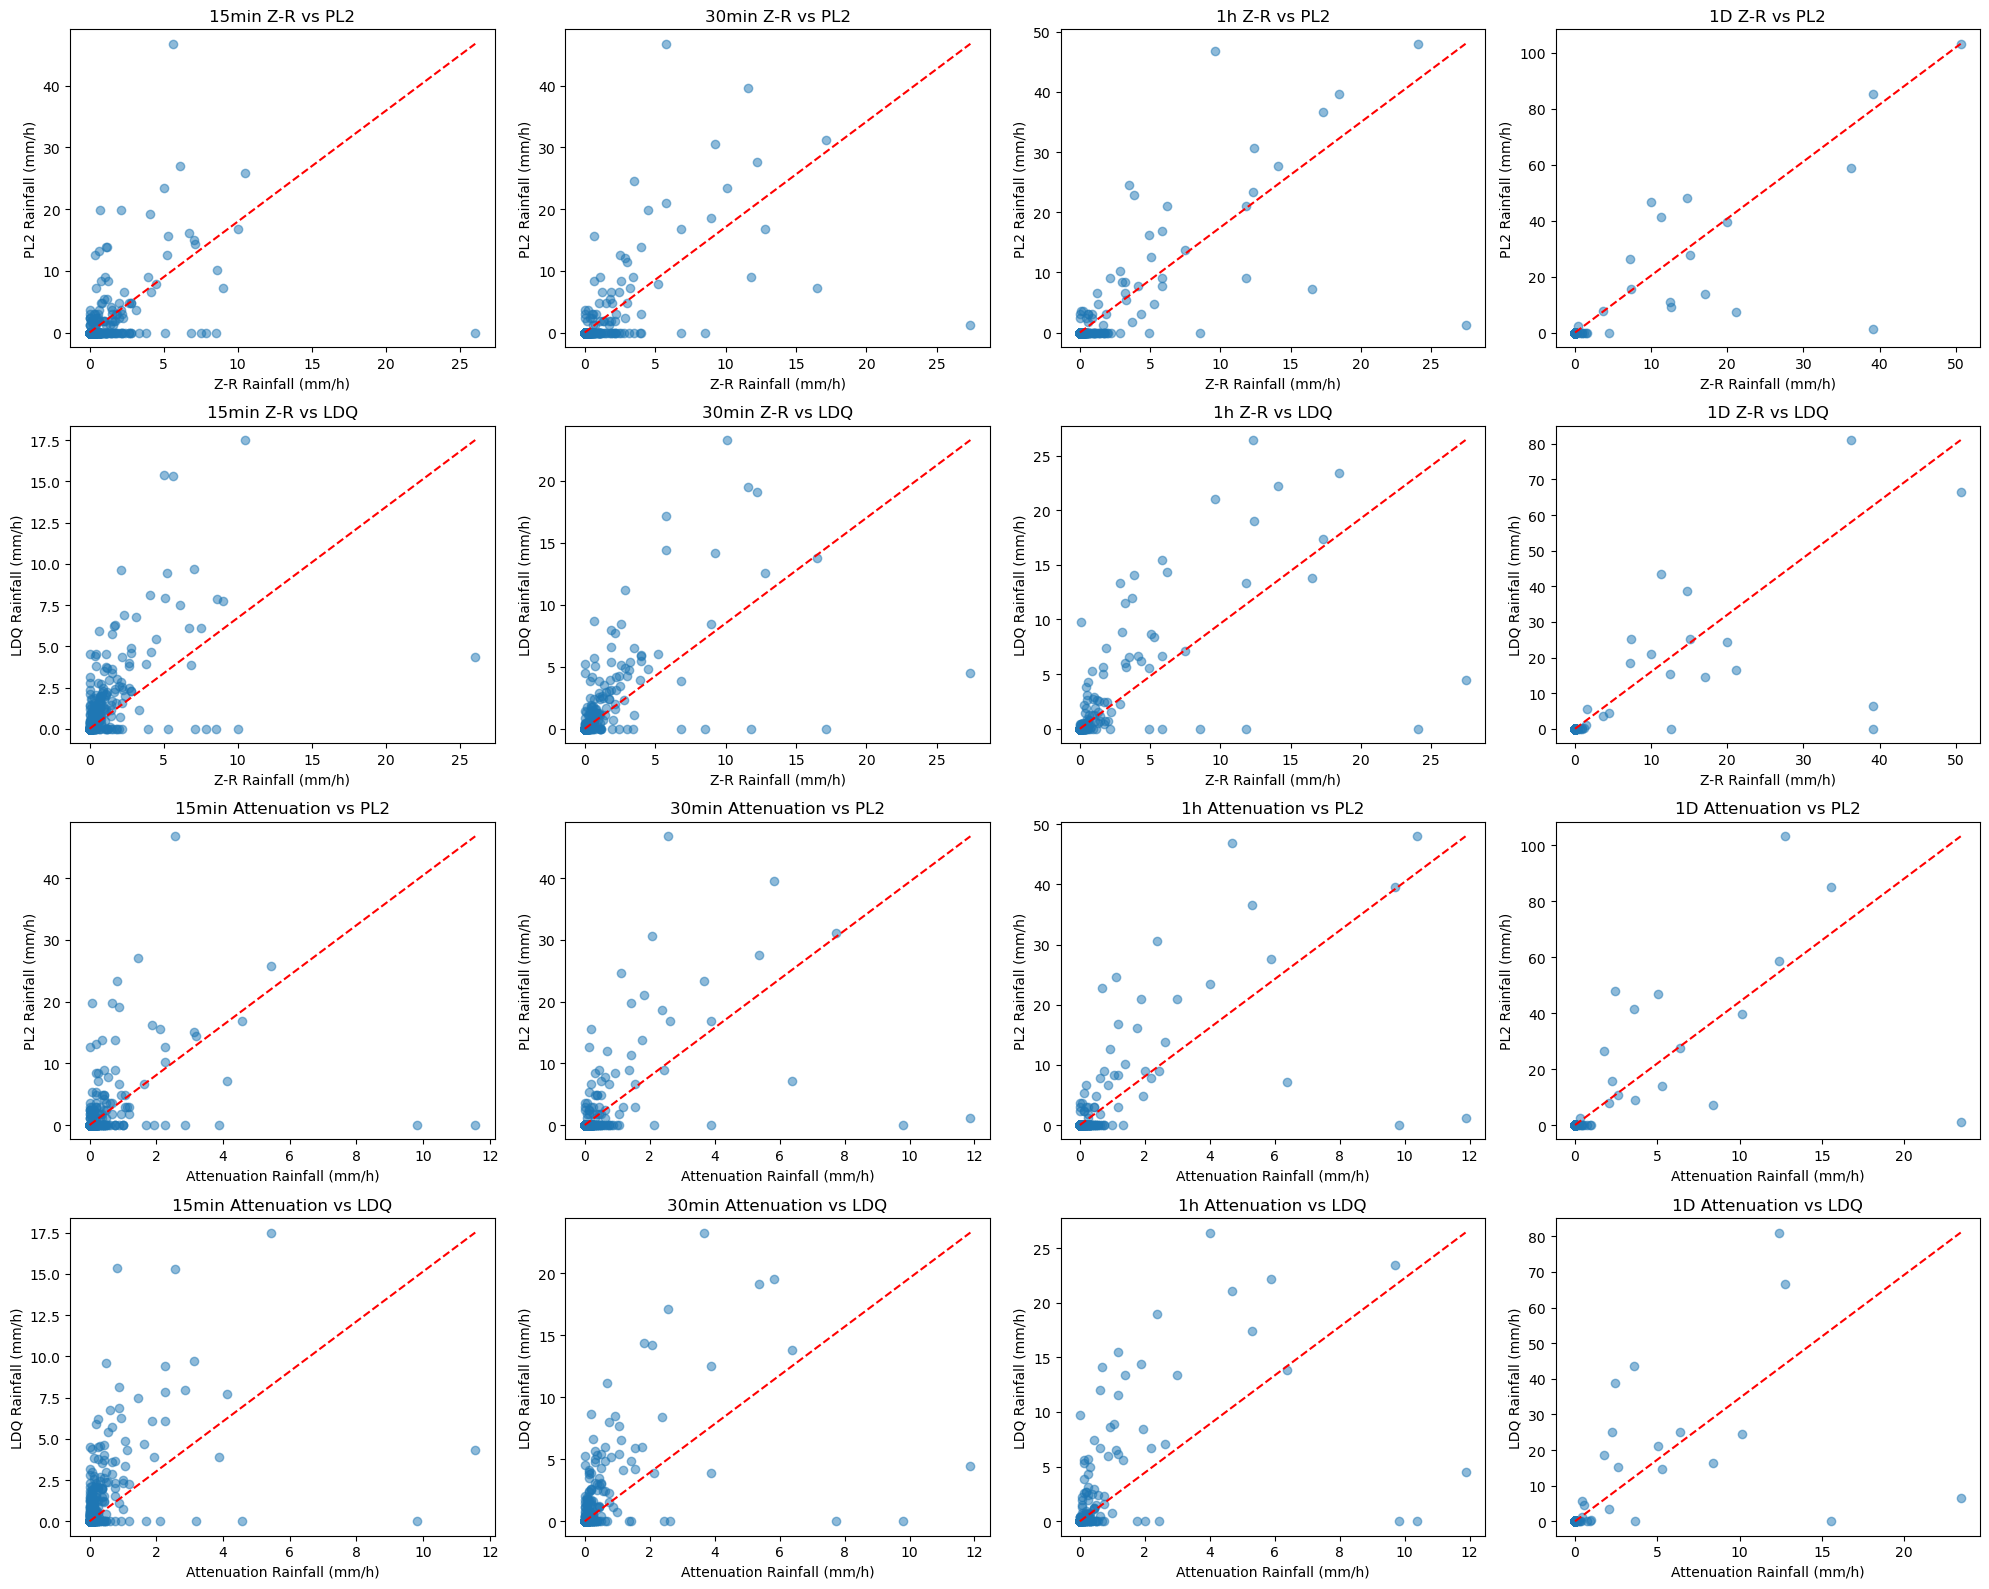

In [39]:
import matplotlib.pyplot as plt

intervals = ['15min', '30min', '1h', '1D']
accumulations = calculate_accumulations(merged_df, ['rain_rate_zr', 'rain_rate_A', 'rain_pl2', 'rain_ldq'], intervals)

# grid 
fig, axes = plt.subplots(4, 4, figsize=(20, 16))

for i, interval in enumerate(intervals):
    accumulation = accumulations[interval]
    
    # Z-R vs PL2
    axes[0, i].scatter(accumulation['rain_rate_zr'], accumulation['rain_pl2'], alpha=0.5)
    axes[0, i].plot([accumulation['rain_rate_zr'].min(), accumulation['rain_rate_zr'].max()],
                    [accumulation['rain_pl2'].min(), accumulation['rain_pl2'].max()], 'r--')
    axes[0, i].set_title(f'{interval} Z-R vs PL2')
    axes[0, i].set_xlabel('Z-R Rainfall (mm/h)')
    axes[0, i].set_ylabel('PL2 Rainfall (mm/h)')

    # Z-R vs LDQ
    axes[1, i].scatter(accumulation['rain_rate_zr'], accumulation['rain_ldq'], alpha=0.5)
    axes[1, i].plot([accumulation['rain_rate_zr'].min(), accumulation['rain_rate_zr'].max()],
                    [accumulation['rain_ldq'].min(), accumulation['rain_ldq'].max()], 'r--')
    axes[1, i].set_title(f'{interval} Z-R vs LDQ')
    axes[1, i].set_xlabel('Z-R Rainfall (mm/h)')
    axes[1, i].set_ylabel('LDQ Rainfall (mm/h)')

    # Attenuation-based vs PL2
    axes[2, i].scatter(accumulation['rain_rate_A'], accumulation['rain_pl2'], alpha=0.5)
    axes[2, i].plot([accumulation['rain_rate_A'].min(), accumulation['rain_rate_A'].max()],
                    [accumulation['rain_pl2'].min(), accumulation['rain_pl2'].max()], 'r--')
    axes[2, i].set_title(f'{interval} Attenuation vs PL2')
    axes[2, i].set_xlabel('Attenuation Rainfall (mm/h)')
    axes[2, i].set_ylabel('PL2 Rainfall (mm/h)')

    # Attenuation-based vs LDQ
    axes[3, i].scatter(accumulation['rain_rate_A'], accumulation['rain_ldq'], alpha=0.5)
    axes[3, i].plot([accumulation['rain_rate_A'].min(), accumulation['rain_rate_A'].max()],
                    [accumulation['rain_ldq'].min(), accumulation['rain_ldq'].max()], 'r--')
    axes[3, i].set_title(f'{interval} Attenuation vs LDQ')
    axes[3, i].set_xlabel('Attenuation Rainfall (mm/h)')
    axes[3, i].set_ylabel('LDQ Rainfall (mm/h)')

plt.tight_layout()

plt.show()


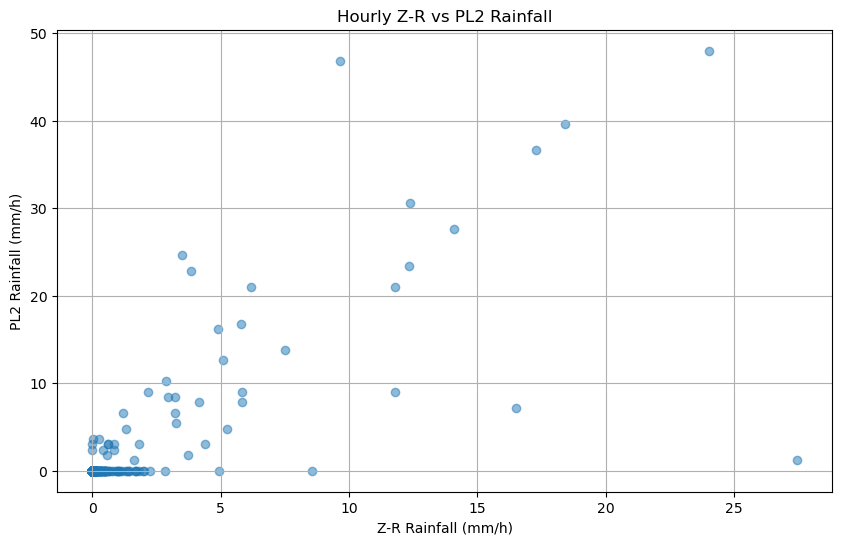

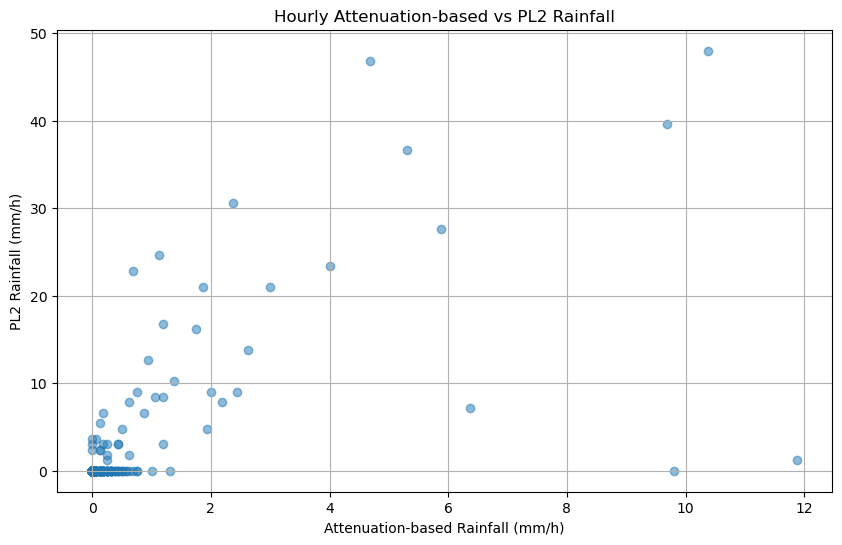

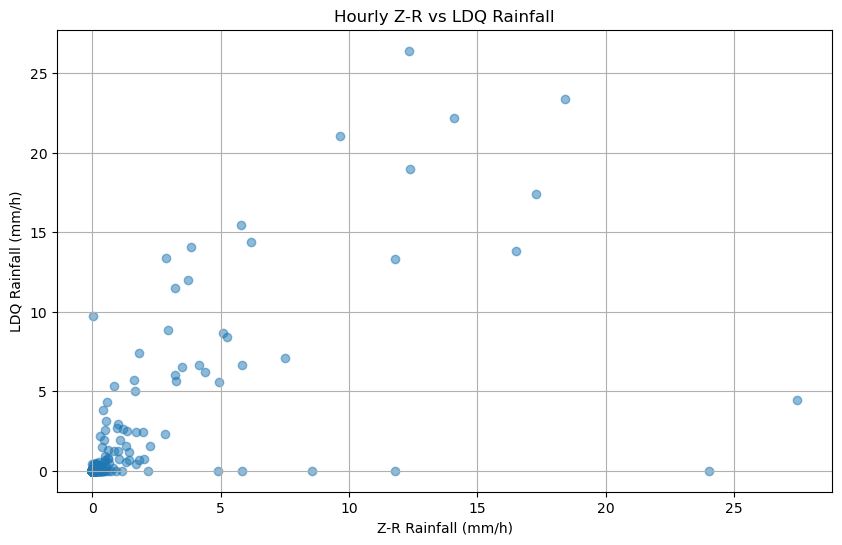

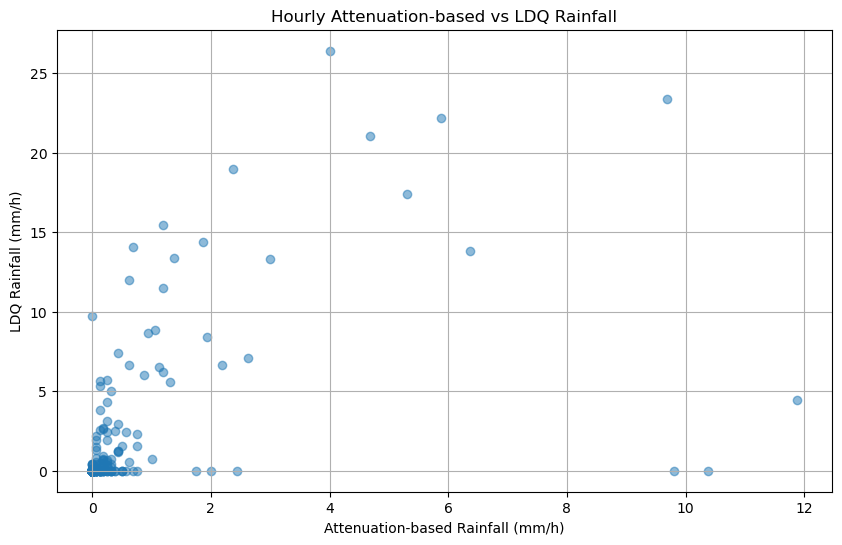

In [40]:

intervals = ['15min', '30min', '1h', '1D']
accumulations = calculate_accumulations(merged_df, ['rain_rate_zr', 'rain_rate_A', 'rain_pl2', 'rain_ldq'], intervals)
hourly_accumulation = accumulations['1h']

plot_scatter(hourly_accumulation, 'rain_rate_zr', 'rain_pl2', 'Hourly Z-R vs PL2 Rainfall', 'Z-R Rainfall (mm/h)', 'PL2 Rainfall (mm/h)')
plot_scatter(hourly_accumulation, 'rain_rate_A', 'rain_pl2', 'Hourly Attenuation-based vs PL2 Rainfall', 'Attenuation-based Rainfall (mm/h)', 'PL2 Rainfall (mm/h)')
plot_scatter(hourly_accumulation, 'rain_rate_zr', 'rain_ldq', 'Hourly Z-R vs LDQ Rainfall', 'Z-R Rainfall (mm/h)', 'LDQ Rainfall (mm/h)')
plot_scatter(hourly_accumulation, 'rain_rate_A', 'rain_ldq', 'Hourly Attenuation-based vs LDQ Rainfall', 'Attenuation-based Rainfall (mm/h)', 'LDQ Rainfall (mm/h)')


Histogram of Hourly Rainfall


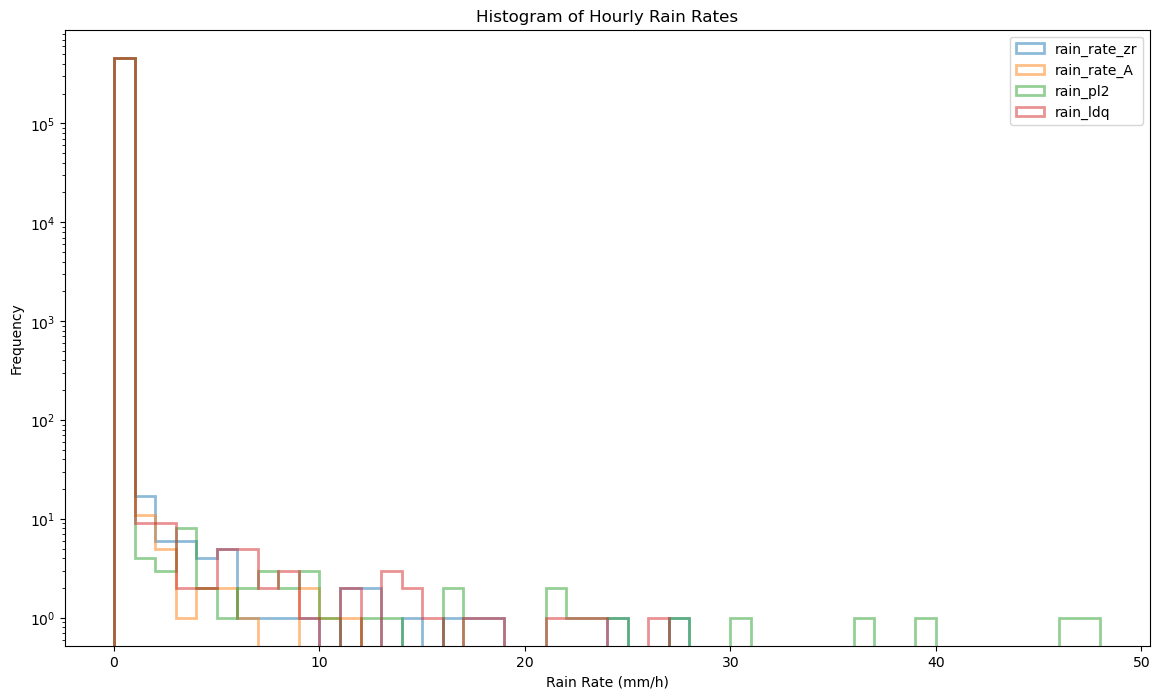

In [41]:

plot_histogram(hourly_accumulation, ['rain_rate_zr', 'rain_rate_A', 'rain_pl2', 'rain_ldq'], 'Histogram of Hourly Rain Rates')



#### Statistical Analysis

Calculate bias, RMSE, and correlation between the Z-R, attenuation-based rain rates, and the pl2 and ldq as truth.


In [42]:

estimate_cols = ['rain_rate_zr', 'rain_rate_A', 'rain_ldq']
stats_pl2 = calculate_statistics(merged_df, 'rain_pl2', estimate_cols)
stats_ld = calculate_statistics(merged_df, 'rain_ld', estimate_cols)

print("Statistics compared to PL2 (truth):")
print(stats_pl2)
print("\nStatistics compared to LD (truth):")
print(stats_ld)


Statistics compared to PL2 (truth):
             rain_rate_zr  rain_rate_A  rain_ldq
Bias            -0.244686    -0.596832 -0.062430
RMSE             2.718559     2.684866  2.770417
Correlation      0.230985     0.191626  0.435017

Statistics compared to LD (truth):
             rain_rate_zr  rain_rate_A  rain_ldq
Bias            -0.139854    -0.492001  0.028603
RMSE             1.209917     1.205888  0.104237
Correlation      0.600034     0.490210  0.997267


#### Time Series 
Also, plot the time series


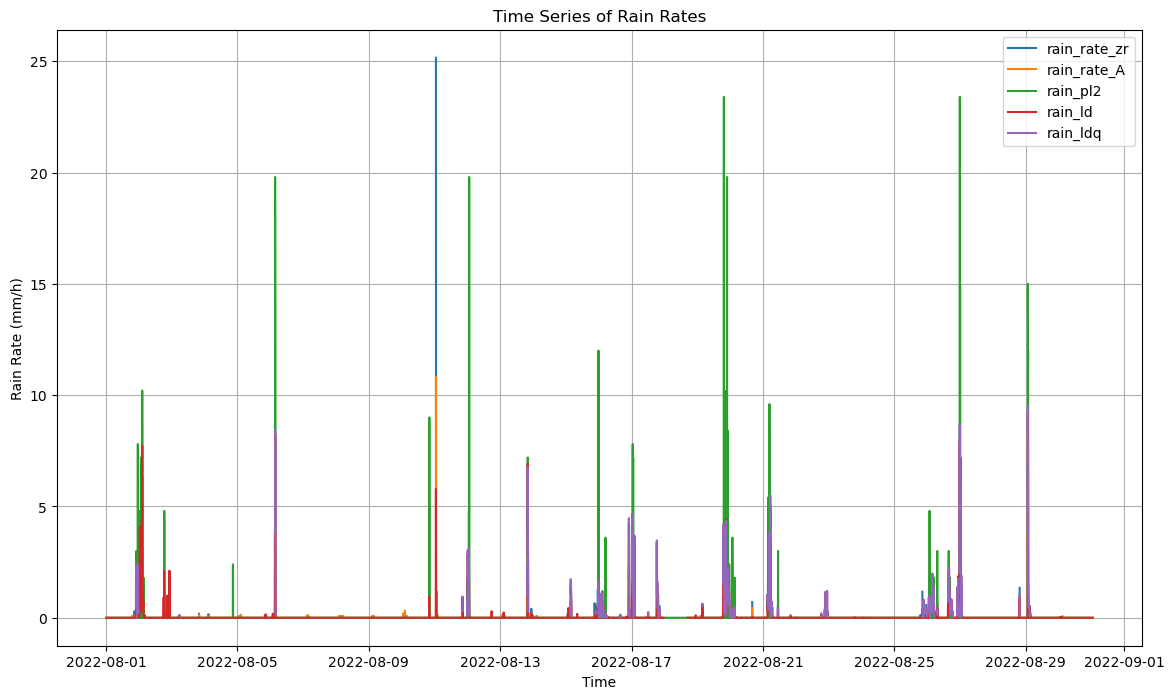

In [43]:

time_series_columns = ['rain_rate_zr', 'rain_rate_A', 'rain_pl2', 'rain_ld', 'rain_ldq']
plot_time_series(merged_df, time_series_columns, 'Time Series of Rain Rates')


#### Scatter Plot Comparisons with PL2 and LD



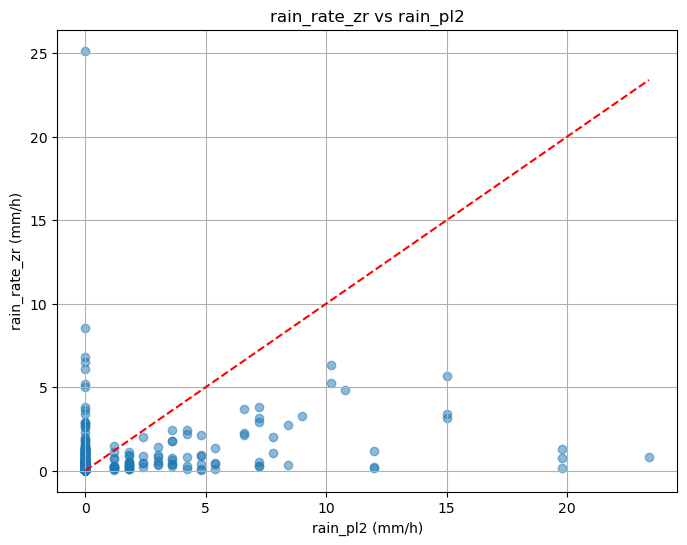

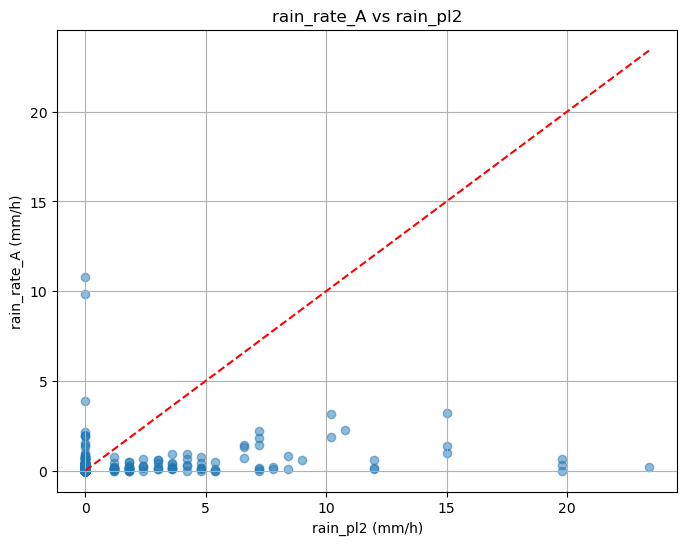

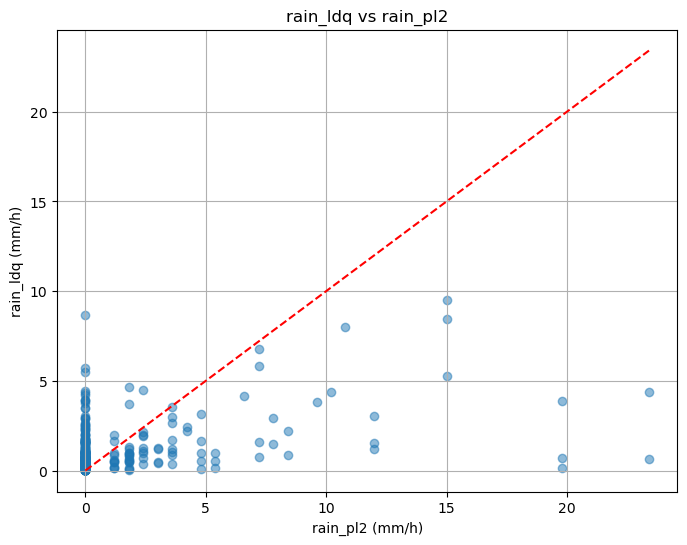

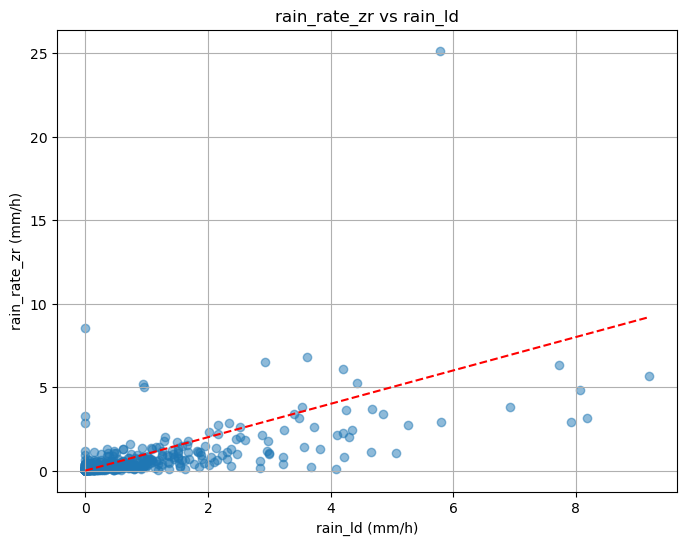

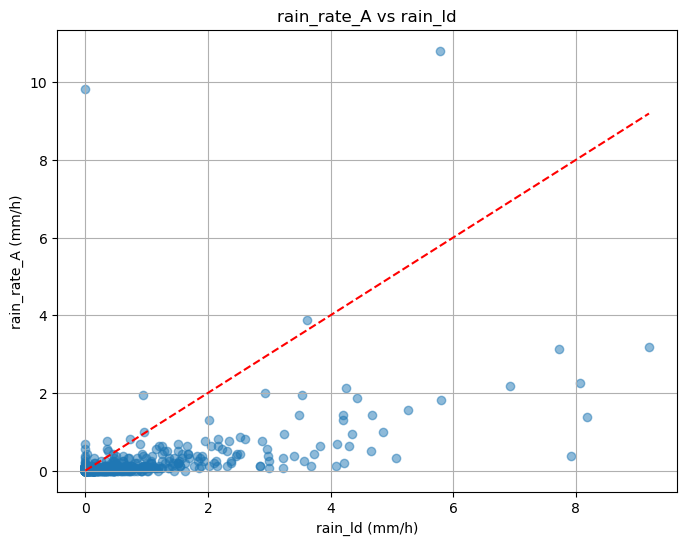

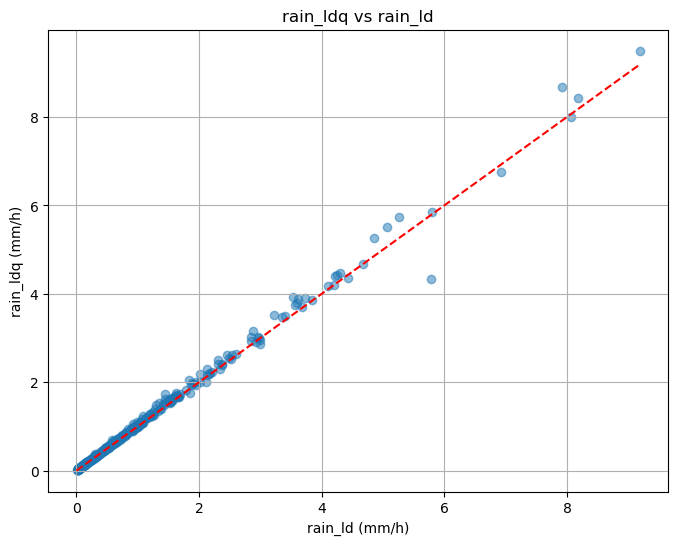

In [44]:


plot_scatter_comparison(merged_df, 'rain_pl2', estimate_cols)
plot_scatter_comparison(merged_df, 'rain_ld', estimate_cols)


## Conclusion

We compared rainfall estimations from radar attenuation and ZR based rain rates, laser disdrometer data, and gauge measurements. 
The Z-R relationship and attenuation-based estimates, provide broad spatial coverage but underestimated rainfall during moderate to intense events. The Z-R method performed better than attenuation-based. Ground-based Pluvio2 and LD/LDQuant disdrometers are considedred precise, but localized measurements and shows higher rainfall.